In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Misc Functions

In [2]:
def create_dataset(N, minval=[0, 0], maxval=[1, 1]):
    dataset = np.zeros((N, 3))

    x_data = np.random.rand(N) * (maxval[0] - minval[0]) + minval[0]
    y_data = np.random.rand(N) * (maxval[1] - minval[1]) + minval[1]

    dataset[:, 0] = np.arange(N)
    dataset[:, 1] = x_data
    dataset[:, 2] = y_data

    return dataset

def plot_dataset(dataset):
    plt.figure(figsize=(8, 8))
    plt.scatter(dataset[:, 1], dataset[:, 2])
    plt.show()


def sort_dataset(dataset, axis="x"):
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2

    N = dataset.shape[0] 
    datapoints = []
    for i in range(N):
        datapoints.append(list(dataset[i]))

    sorted_dataset = np.stack(list(sorted(datapoints, key=lambda p: p[axis])))

    return sorted_dataset

In [3]:
def compute_median(dataset, axis="x"):
    """
    주어진 데이터포인트에 대해 median 값 반환
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
        
    median = np.median(dataset[:, axis])
    
    return median

In [4]:
def compute_distance(p1, p2):
    """
    주어진 2개 데이터포인트에 대해 거리 계산
    """
    
    distance = np.sqrt(np.sum((p1[1:] - p2[1:])**2))
    return distance

In [5]:
def get_median_points(sorted_dataset, median, d, axis="x"):
    """
    Median 근처의 데이터포인트(좌우 d 이하로 떨어진) 찾아서 반환
    MOTE: sorted_dataset은 axis와 반대 축으로 정렬된 리스트여야 함
          -> 여기서는 항상 y_sorted_dataset
    """
    
    if axis == "x":
        axis = 1
    elif axis == "y":
        axis = 2
    
    filtered_dataset = sorted_dataset[
        (sorted_dataset[:, axis] >= median - d) & (sorted_dataset[:, axis] <= median + d)
    ]
    return filtered_dataset

# Merge

메디안 앞뒤로 왼쪽, 오른쪽 구역에 걸쳐있는 점의 쌍의 거리를 계산한다.

In [10]:
def compute_median_closest_pair(median_datapoints, d, along_axis="y"):
    """
    Median 근처 데이터포인트들에서 closest pair 계산 -> merge
    """
    
    if along_axis == "x":
        along_axis = 1
    elif along_axis == "y":
        along_axis = 2
    
    N = median_datapoints.shape[0]
    min_distance = d
    closest_point_pair = None
    
    if N > 0:
        # y축 기준 제일 작은 포인트부터 루프
        for i in range(N):
            datapoint = median_datapoints[i]

            filtered_median_datapoints = []
            for j in range(i+1, N):
                point = median_datapoints[j]
                
                # 현재 데이터포인트부터 y축 값이 큰 값의 데이터포인트를 차례대로 얻어오고, 그 값이 범위내에 있는지 검사
                if point[along_axis] <= datapoint[along_axis] + d:
                    filtered_median_datapoints.append(point)
                # 범위내에 없으면 더 검사할 필요 없이 break
                else:
                    break
            
            if len(filtered_median_datapoints) == 0:
                continue
                
            # 편의를 위해 numpy array로 바꿔주는 코드
            filtered_median_datapoints = np.stack(filtered_median_datapoints, axis=0)

            # 걸러진 포인트개수
            M = filtered_median_datapoints.shape[0]

            # closest pair 계산
            for j in range(M):
                point = filtered_median_datapoints[j]
                dist = compute_distance(datapoint, point)

                if dist < min_distance:
                    min_distance = dist
                    closest_point_pair = (datapoint, point)
                
    return closest_point_pair

# Divide-and-Conquer Algorithm

In [7]:
def compute_closest_pair(x_sorted_dataset, y_sorted_dataset):
    """
    Closest pair 계산 알고리즘
    """
    
    N = x_sorted_dataset.shape[0]
    if N == 1:                  # 해당 영역에 데이터포인트가 하나밖에 없는 경우
        return None
    elif N == 2:                # 해당 영역에 데이터포인트가 두개밖에 없는 경우
        p1 = x_sorted_dataset[0]
        p2 = x_sorted_dataset[1]
        return (p1, p2)
    else:                       # 해당 영역에 데이터포인트가 2개 이상인 경우
        # median 값 계산
        x_median = compute_median(x_sorted_dataset, axis="x")
        
        # median 값 기준으로 좌우로 데이터셋을 나눔
        dataset_left_x = x_sorted_dataset[x_sorted_dataset[:, 1] <= x_median]
        dataset_right_x = x_sorted_dataset[x_sorted_dataset[:, 1] > x_median]
        
        dataset_left_y = y_sorted_dataset[y_sorted_dataset[:, 1] <= x_median]
        dataset_right_y = y_sorted_dataset[y_sorted_dataset[:, 1] > x_median]
        
        # 좌우 영역에서 각각 closest pair 계산
        pair_left = compute_closest_pair(dataset_left_x, dataset_left_y)
        pair_right = compute_closest_pair(dataset_right_x, dataset_right_y)

        
        if pair_left is None:  # 좌측 영역에 데이터포인트가 1개밖에 없었을 경우
            min_distance_left = np.inf
        else:
            min_distance_left = compute_distance(pair_left[0], pair_left[1])
            
        if pair_right is None: # 우측 영역에 데이터포인트가 1개밖에 없었을 경우
            min_distance_right = np.inf
        else:
            min_distance_right = compute_distance(pair_right[0], pair_right[1])
        
        # 좌우측의 closest pair를 바탕으로 전체(?) closest pair 계산
        if min_distance_left < min_distance_right:
            min_distance = min_distance_left
            closest_pair = pair_left
        elif min_distance_left > min_distance_right:
            min_distance = min_distance_right
            closest_pair = pair_right
        
        # median 근처의 데이터포인트만 얻어옴
        median_points = get_median_points(y_sorted_dataset, x_median, min_distance, axis="x")
        
        # median 근처 포인트들 중에서 closest pair 계산
        median_closest_pair = compute_median_closest_pair(median_points, min_distance, along_axis="y")
        
        # closest pair가 median 근처에 있었을 경우, global closest pair 업데이트
        if median_closest_pair is not None:
            closest_pair = median_closest_pair
        
        return closest_pair

# Test

In [11]:
dataset = create_dataset(N=100)
x_sorted_dataset = sort_dataset(dataset, axis="x")
y_sorted_dataset = sort_dataset(dataset, axis="y")

pair = compute_closest_pair(x_sorted_dataset, y_sorted_dataset)
print(pair, compute_distance(*pair))

(array([3.60000000e+01, 9.88936736e-01, 3.46693001e-04]), array([7.50000000e+01, 9.99093840e-01, 7.85943936e-03])) 0.012633610930093858


In [12]:
def check(dataset):
    N = dataset.shape[0]
    
    min_dist = np.inf
    closest_pair = None
    
    for i in range(N):
        for j in range(i + 1, N):
            p1 = dataset[i]
            p2 = dataset[j]
            
            dist = compute_distance(p1, p2)
            if dist < min_dist:
                min_dist = dist
                closest_pair = (p1, p2)
                
    return closest_pair

In [13]:
pair_check = check(dataset)
print(pair_check, compute_distance(*pair_check))

(array([3.60000000e+01, 9.88936736e-01, 3.46693001e-04]), array([7.50000000e+01, 9.99093840e-01, 7.85943936e-03])) 0.012633610930093858


In [14]:
def unit_test(n_iter):
    for i in range(n_iter):
        test_dataset = create_dataset(N=10000)
        x_sorted_test_dataset = sort_dataset(test_dataset, axis="x")
        y_sorted_test_dataset = sort_dataset(test_dataset, axis="y")

        pair1 = compute_closest_pair(x_sorted_test_dataset, y_sorted_test_dataset)
        pair2 = check(test_dataset)
        
        dist1 = compute_distance(*pair1)
        dist2 = compute_distance(*pair2)
        
        assert dist1 == dist2, f"테스트실패! pair1: {pair1}, pair2: {pair2}, distance: {dist1}, {dist2}"
        
    print("테스트성공")

In [15]:
unit_test(10)

테스트성공


# 실행시간 그래프

In [17]:
def test_with_n(N):
    dataset = create_dataset(N)
    
    start_time = time.time()
    x_sorted_test_dataset = sort_dataset(dataset, axis="x")
    y_sorted_test_dataset = sort_dataset(dataset, axis="y")
    
    closest_pair = compute_closest_pair(x_sorted_test_dataset, y_sorted_test_dataset)
    duration = time.time() - start_time
    
    return duration

In [35]:
def test_naive_with_n(N):
    dataset = create_dataset(N)
    start_time = time.time()
    closest_pair = check(dataset)
    duration = time.time() - start_time
    
    return duration

In [ ]:
Ns = [1000, 5000, 10000, 50000, 100000]

durations = []
for n in Ns:
    duration = 0.0
    for i in range(3):
        duration += test_with_n(n)
        
    durations.append(duration/3)

In [38]:
naive_Ns = [1000, 5000, 10000]

naive_durations = []
for n in naive_Ns:
    duration = 0.0
    for i in range(3):
        duration += test_naive_with_n(n)
        
    naive_durations.append(duration/3)

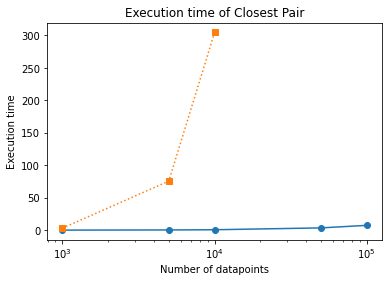

In [39]:
#plt.figure(figsize=(8, 8))
plt.plot(Ns, durations, linestyle='-', marker='o')
plt.plot(naive_Ns, naive_durations, linestyle=':', marker='s')
plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")
plt.title("Execution time of Closest Pair")
plt.xscale('log')
plt.show()